# Práctica 3

## TAREA 1

#### TAREA 1: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedasW y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. 

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo. 

Comenzamos importando las librerías necesarias y definiendo el radio de las monedas.

In [2]:
# --- Importación de librerías ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import os

# --- Parámetros generales ---
RADIO_MONEDAS = {
    0.01: 8.125,
    0.02: 9.375,
    0.05: 10.625,
    0.10: 9.875,
    0.20: 11.125,
    0.50: 12.125,
    1.00: 11.625,
    2.00: 12.875
}

Llevamos a cabo un preprocesamiento de la imagen empleando diferentes técnicas (en la ejecución del programa se indica qué técnica utilizar).

In [3]:
# --- 1) Preprocesamiento de imagen ---
def cargar_y_preprocesar(ruta_img, metodo='gris'):
    """ Carga la imagen desde una ruta y aplica preprocesamiento."""
    img = cv2.imread(ruta_img)
    if img is None:
        return None, None
    
    if metodo == 'gris':
        img_procesada = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_procesada = cv2.medianBlur(img_procesada, 7)
    elif metodo == 'threshold':
        img_procesada = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, img_procesada = cv2.threshold(img_procesada, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    else:
        img_procesada = img.copy()
    
    return img, img_procesada

A continuación, detectamos las monedas de la imagen y seleccionamos una referencial.

In [ ]:
# --- 2) Detección de monedas ---
def detectar_monedas(img, metodo='hough', radio_min=40, radio_max=160, area_min=200):
    """ Detecta monedas en una imagen usando HoughCircles o contornos. """
    monedas = []

    if metodo == 'hough':
        circ = cv2.HoughCircles(
            img, cv2.HOUGH_GRADIENT, dp=1,
            minDist=80, param1=100, param2=50,
            minRadius=radio_min, maxRadius=radio_max
        )

        if circ is not None:
            circ = np.uint16(np.around(circ))
            monedas = [{'center': (int(x), int(y)), 'r_px': int(r)} for x, y, r in circ[0, :]]

    elif metodo == 'contours':
        contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for c in contours:
            if cv2.contourArea(c) < area_min:
                continue

            (cx, cy), r = cv2.minEnclosingCircle(c)
            monedas.append({'center': (int(cx), int(cy)), 'r_px': r, 'contour': c})

    return monedas

# --- 3) Selección de referencia ---
def seleccionar_moneda_referencia(img, monedas):
    """ Permite al usuario seleccionar la moneda de referencia haciendo clic sobre la imagen. """
    coords = []

    def click(event, x, y, *_):
        if event == cv2.EVENT_LBUTTONDOWN:
            coords.append((x, y))
            cv2.destroyAllWindows()

    disp = img.copy()
    for c in monedas:
        cv2.circle(disp, c['center'], int(c['r_px']), (255, 0, 0), 1)
    cv2.imshow("Clic en moneda de referencia", disp)
    cv2.setMouseCallback("Clic en moneda de referencia", click)
    cv2.waitKey(0)
    
    if not coords:
        return None, None
    
    x, y = coords[0]
    idx_ref = int(np.argmin([math.hypot(c['center'][0]-x, c['center'][1]-y) for c in monedas]))
    return monedas[idx_ref], idx_ref

En base a la moneda referencial, se calculan las escalas y  se clasifican el conjunto de monedas.

In [ ]:
# --- 4) Calcular escala ---
def calcular_escala(ref_moneda):
    """ Calcula la escala de milímetros por píxel a partir de la moneda de referencia. """
    try:
        cadena = input("Valor de la moneda clicada (ej: 1 para 1€, 0.1 para 0.10€): ")
        cadena = cadena.strip().replace(',', '.').replace('€', '').strip()
        valor_ref = float(cadena)
    except:
        print("Entrada no válida")
        return None, None
    
    if valor_ref not in RADIO_MONEDAS:
        claves = sorted(RADIO_MONEDAS.keys())
        closest = min(claves, key=lambda k: abs(k - valor_ref))
        ans = input(f"Valor {valor_ref} no reconocido. ¿Usar {closest}€ como referencia? (s/n): ")
        if ans.lower().startswith('s'):
            valor_ref = closest
        else:
            return None, None
    
    escala = RADIO_MONEDAS[valor_ref] / ref_moneda['r_px']
    return escala, valor_ref

# --- 5) Clasificación de monedas ---
def clasificar_monedas(monedas, escala, rel_tol=0.12, abs_tol_mm=1.5):
    """ Clasifica cada moneda según su radio en milímetros y calcula el total. """
    total = 0
    resultados = []
    for c in monedas:
        cx, cy, r_px = *c['center'], c['r_px']
        radio_mm = r_px * escala
        dists = {v: abs(RADIO_MONEDAS[v] - radio_mm) for v in RADIO_MONEDAS}
        asignado = min(dists, key=dists.get)
        diff_mm = dists[asignado]
        diff_pct = diff_mm / RADIO_MONEDAS[asignado]
        confident = (diff_mm <= abs_tol_mm) or (diff_pct <= rel_tol)
        if confident:
            total += asignado
        else:
            asignado = None
        resultados.append({
            'center': (cx, cy),
            'r_px': r_px,
            'radio_mm': radio_mm,
            'assigned': asignado,
            'diff_mm': diff_mm,
            'diff_pct': diff_pct,
            'confident': confident
        })
    return total, resultados

Gestionamos la visualización de la imagen, así como generar un muestreo de los rellenos.

In [ ]:
# --- 6) Imagen de rellenos ---
def crear_rellenos(img, monedas):
    """ Crea una imagen con círculos blancos rellenos donde se detectaron las monedas. """
    img_rellenos = np.zeros_like(img)
    for c in monedas:
        cx, cy, r_px = *c['center'], int(c['r_px'])
        cv2.circle(img_rellenos, (cx, cy), r_px, (255, 255, 255), -1)
    return img_rellenos

# --- 7) Visualización y guardado ---
def mostrar_resultados(img, img_rellenos, resultados, total, ruta_salida):
    """ Muestra y guarda una visualización combinada de la imagen original, rellenos y resultados. """
    salida = img.copy()
    for r in resultados:
        cx, cy, r_px, valor = *r['center'], int(r['r_px']), r['assigned']
        if valor is not None:
            cv2.circle(salida, (cx, cy), r_px, (0, 255, 0), 2)
            cv2.putText(salida, f"{valor:.2f}", (cx-50, cy), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 2)
    
    os.makedirs("salidas", exist_ok=True)
    cv2.imwrite(ruta_salida, salida)

    altura, ancho, _ = img.shape
    linea = np.ones((altura, 10, 3), dtype=np.uint8) * 0
    combinado = np.hstack([img, linea, img_rellenos, linea, salida])

    plt.figure(figsize=(24, 8))
    plt.imshow(cv2.cvtColor(combinado, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Total detectado: {total:.2f} €")
    plt.show()

Finalmente, estructuramos el programa para poder ejecutarlo correctamente.

In [ ]:
# --- 8) Función principal ---
def contar_monedas(ruta_img, metodo='hough'):
    """ Cuenta monedas en una imagen usando HoughCircles o contornos (umbral). """
    if metodo == 'hough':
        img, img_procesada = cargar_y_preprocesar(ruta_img, metodo='gris')
        metodo_detector = 'hough'

    else:
        img, img_procesada = cargar_y_preprocesar(ruta_img, metodo='threshold')
        metodo_detector = 'contours'

    if img is None:
        print("No se pudo cargar la imagen.")
        return 0, []

    monedas = detectar_monedas(img_procesada, metodo=metodo_detector)
    if not monedas:
        print("No se detectaron monedas.")
        return 0, []

    print(f"1️⃣ Número de monedas detectadas: {len(monedas)}")
    img_rellenos = crear_rellenos(img, monedas)

    ref_moneda, _ = seleccionar_moneda_referencia(img, monedas)
    if ref_moneda is None:
        print("No se seleccionó moneda de referencia.")
        return 0, monedas

    escala, valor_ref = calcular_escala(ref_moneda)
    if escala is None:
        print("No se pudo calcular escala.")
        return 0, monedas

    print(f"2️⃣ Moneda de referencia seleccionada: {valor_ref:.2f} €")

    total, resultados = clasificar_monedas(monedas, escala)
    print(f"3️⃣ Dinero total detectado: {total:.2f} €")

    nombre = os.path.splitext(os.path.basename(ruta_img))[0]
    ruta_salida = f"salidas/{nombre}_resultado.jpg"
    mostrar_resultados(img, img_rellenos, resultados, total, ruta_salida)

    return total, resultados

# --- Ejecución ---
if __name__ == "__main__":
    RUTA_IMAGEN = "recursos/tarea1/Monedas1.jpg"

    if not os.path.exists(RUTA_IMAGEN):
        print(f"No existe la imagen cuya ruta es: '{RUTA_IMAGEN}'")
    else:
        total_calculado, resultados_finales = contar_monedas(RUTA_IMAGEN, metodo='hough')

## TAREA 2

TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

In [8]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import seaborn as sns

##### Identificación de características geométricas y de color de un entorno

In [9]:
def detectar_caracteristicas(contours, imagen_hsv):
    """Calcula las características de un contorno dado y la imagen en espacio HSV."""
    # Área y perímetro
    area = cv2.contourArea(contours)
    perimetro = cv2.arcLength(contours, True)
    if area == 0:
        return None

    # Compacidad, relación ancho/alto, relación área contenedor
    compacidad = (perimetro ** 2) / area
    x, y, w, h = cv2.boundingRect(contours)
    rel_area_contenedor = area / (w * h)
    rel_ancho_alto = w / h if h != 0 else 0

    # Relación ejes de la elipse, relación distancias al centroide
    if len(contours) >= 5:
        ellipse = cv2.fitEllipse(contours)
        (_, axes, _) = ellipse
        major, minor = max(axes), min(axes)
        excentricidad = np.sqrt(1 - (minor / major) ** 2)
    else:
        excentricidad = 0

    # Relación distancias al centroide
    M = cv2.moments(contours)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        dist = np.sqrt((contours[:, 0, 0] - cx) ** 2 + (contours[:, 0, 1] - cy) ** 2)
        rel_distance = dist.min() / dist.max() if dist.max() > 0 else 0
    else:
        rel_distance = 0
    
    # Tono de color dominante (canal H en espacio HSV)
    mask = np.zeros(imagen_hsv.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [contours], -1, 255, -1)
    h_vals = imagen_hsv[:, :, 0][mask == 255]

    # Crear histograma del canal H (tonos de color)
    hist = cv2.calcHist([h_vals.astype('float32')], [0], None, [180], [0, 180])
    dominant_bin = np.argmax(hist)

    tono_dominante = dominant_bin

    # Media y desviación estándar de los canales HSV
    mask = np.zeros(imagen_hsv.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [contours], -1, 255, -1)
    h_vals = imagen_hsv[:, :, 0][mask == 255]
    s_vals = imagen_hsv[:, :, 1][mask == 255]
    v_vals = imagen_hsv[:, :, 2][mask == 255]
    mean_h, mean_s, mean_v = np.mean(h_vals), np.mean(s_vals), np.mean(v_vals)
    std_h, std_s, std_v = np.std(h_vals), np.std(s_vals), np.std(v_vals)

    return {
        "area": area,
        "perimetro": perimetro,
        "compacidad": compacidad,
        "rel_ancho_alto": rel_ancho_alto,
        "rel_area_contenedor": rel_area_contenedor,
        "rel_ejes_elipse": excentricidad,
        "rel_distancias": rel_distance,
        "tono_dominante": tono_dominante,
        "mean_h": mean_h,
        "mean_s": mean_s,
        "mean_v": mean_v,
        "std_h": std_h,
        "std_s": std_s,
        "std_v": std_v
    }


##### Procesamiento de imágenes y extracciones de imágenes

In [10]:
def extraer_caracteristicas_imagen(imagen_path):
    """Extrae características de todos los objetos en una imagen dada su ruta."""
    
    img_gray = cv2.imread(imagen_path, cv2.IMREAD_GRAYSCALE)
    if img_gray is None:
        print(f"⚠️ No se pudo cargar la imagen: {imagen_path}")
        return []

    img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_color = cv2.imread(imagen_path, cv2.IMREAD_COLOR)
    img_hsv = cv2.cvtColor(img_color, cv2.COLOR_BGR2HSV)

    caracteristicas = []
    for c in contours:
        if 50 < cv2.contourArea(c) < 7000:
            feat = detectar_caracteristicas(c, img_hsv)
            if feat:
                caracteristicas.append(list(feat.values()))
    return caracteristicas


def vector_caracteristicas_medio(imagen_path):
    """Calcula el vector de características promedio de todos los objetos detectados en una imagen."""
    caracteristicas = extraer_caracteristicas_imagen(imagen_path)
    if len(caracteristicas) == 0:
        return None
    return np.mean(np.array(caracteristicas), axis=0)

##### Fase de entrenamiento: se extrae los vectores de características medias por clase de las imágenes de referencia

In [11]:
def entrenar_clasificador(imagenes_referencia):
    """Entrena el clasificador obteniendo el vector de características medio para cada clase."""
    vectores = {}
    for clase, ruta in imagenes_referencia.items():
        v = vector_caracteristicas_medio(ruta)
        if v is not None:
            vectores[clase] = v
    return vectores

##### Normalización y pesos de las características

In [12]:
def preparar_referencias(mean_vectors):
    """Prepara las referencias normalizando los vectores de características."""
    reference_features = np.array(list(mean_vectors.values()))
    scaler = StandardScaler()
    scaler.fit(reference_features)

    mean_vectors_norm = {c: scaler.transform([v])[0] for c, v in mean_vectors.items()}

    weights = np.array([
        1.0,  # area
        1.0,  # perimetro
        3.0,  # compacidad
        1.5,  # rel_ancho_alto
        1.0,  # rel_area_contenedor
        3.0,  # rel_ejes_elipse
        1.5,  # rel_distancias
        0.5,  # tono_dominante
        3.5,  # mean_h 
        2.5,  # mean_s 
        2.5,  # mean_v
        1.0,  # std_h
        1.0,  # std_s
        1.0   # std_v
    ])
    
    return mean_vectors_norm, scaler, weights

##### Clasificación visual de objetos de la imagen de prueba

In [13]:
COLORES = {
    "FRA": (0, 0, 255),   # Rojo 
    "PEL": (0, 255, 0),   # Verde
    "TAR": (255, 0, 0)    # Azul
}

def cargar_anotaciones(csv_path):
    """Carga las anotaciones de un CSV."""
    with open(csv_path, newline="") as file:
        return list(csv.DictReader(file))

def leer_imagen(imagen_path):
    """Lee la imagen en color, escala de grises y HSV."""
    img_color = cv2.imread(imagen_path)
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    img_hsv = cv2.cvtColor(img_color, cv2.COLOR_BGR2HSV)
    return img_color, img_gray, img_hsv

def preprocesar_imagen(img_gray):
    """Aplica blur, umbral adaptativo y apertura morfológica."""
    blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    return thresh

def detectar_contornos(thresh):
    """Encuentra contornos en la imagen binaria."""
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def clasificar_contorno(c, x_min, y_min, x_max, y_max, img_hsv, mean_vectors_norm, scaler, weights):
    """Clasifica un contorno si está dentro de la región de interés."""
    area = cv2.contourArea(c)
    if not (50 < area < 2000):
        return None, None

    M = cv2.moments(c)
    if M["m00"] == 0:
        return None, None
    cx, cy = int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])

    if not (x_min <= cx <= x_max and y_min <= cy <= y_max):
        return None, None

    features = detectar_caracteristicas(c, img_hsv)
    if features is None:
        return None, None

    vector = np.array(list(features.values()))
    vector_norm = scaler.transform([vector])[0]
    distances = {k: np.linalg.norm((vector_norm - v) * weights)
                 for k, v in mean_vectors_norm.items()}
    matched_label = min(distances, key=distances.get)
    return matched_label, cv2.boundingRect(c)

def dibujar_anotacion(img, bbox, label):
    """Dibuja el bounding box y la etiqueta sobre la imagen."""
    x, y, w, h = bbox
    color = COLORES[label]
    cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
    cv2.putText(img, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

def clasificar_imagen_con_anotaciones(imagen_path, csv_path, mean_vectors_norm, scaler, weights):
    """Clasifica objetos en una imagen con anotaciones y devuelve métricas."""
    img_color, img_gray, img_hsv = leer_imagen(imagen_path)
    annotations = cargar_anotaciones(csv_path)
    thresh = preprocesar_imagen(img_gray)
    contours = detectar_contornos(thresh)

    img_real, img_pred = img_color.copy(), img_color.copy()
    y_true, y_pred = [], []

    for row in annotations:
        etiqueta_real = row["label"]
        x_min, y_min, x_max, y_max = map(int, [row["x_min"], row["y_min"], row["x_max"], row["y_max"]])

        dibujar_anotacion(img_real, (x_min, y_min, x_max - x_min, y_max - y_min), etiqueta_real)

        matched_label = "None"
        for c in contours:
            label, bbox = clasificar_contorno(c, x_min, y_min, x_max, y_max, img_hsv, mean_vectors_norm, scaler, weights)
            if label:
                matched_label = label
                dibujar_anotacion(img_pred, bbox, matched_label)
                break

        y_true.append(etiqueta_real)
        y_pred.append(matched_label)

    combined = np.hstack((cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB),
                          cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)))

    return y_true, y_pred, combined


##### Imprimir resultado comparativo

In [14]:
def mostrar_resultado_visual(y_true, y_pred, imagen_combined):
    """Muestra la imagen combinada."""
    plt.figure(figsize=(16, 8))
    plt.imshow(imagen_combined)
    plt.title("Clasificación Real vs Clasificación Predicha")
    plt.axis('off')
    plt.savefig("salidas/comparacion_real_predicha.jpg", dpi=300, bbox_inches="tight")
    plt.show()
    
    aciertos = sum(np.array(y_true) == np.array(y_pred))
    total = len(y_true)
    precision_global = aciertos / total
    print(f"\nAciertos: {aciertos}/{total}")
    print(f"Precisión global: {precision_global * 100:.2f}%")

##### Imprimir matriz de confusión

In [15]:
def mostrar_matriz_confusion(y_true, y_pred, clases):
    """Muestra la matriz de confusión."""
    conf_matrix = confusion_matrix(y_true, y_pred, labels=clases)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, # confusión de matriz 2D array
                annot=True, # muestra número en las celdas
                fmt="d",    # valores enteros
                cbar= False, # sin bara de colores
                cmap="Reds",
                linewidths=0.5,
                square=True,
                xticklabels=clases,
                yticklabels=clases)
    
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de confusión")
    plt.savefig("salidas/matriz_confusion.jpg", dpi=300, bbox_inches="tight")
    plt.show()


##### Métricas del clasificador, derivadas de la matriz de confusión

In [16]:
def imprimir_metricas(y_true, y_pred):
    """Imprime las métricas de evaluación del clasificador."""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print("\n📊 MÉTRICAS DEL CLASIFICADOR")
    print(f"Accuracy (Exactitud): {acc * 100:.2f}%")
    print(f"Precisión: {prec * 100:.2f}%")
    print(f"Recall (Sensibilidad): {rec * 100:.2f}%")
    print(f"Puntaje F1: {f1 * 100:.2f}%")

##### Ejecución del programa

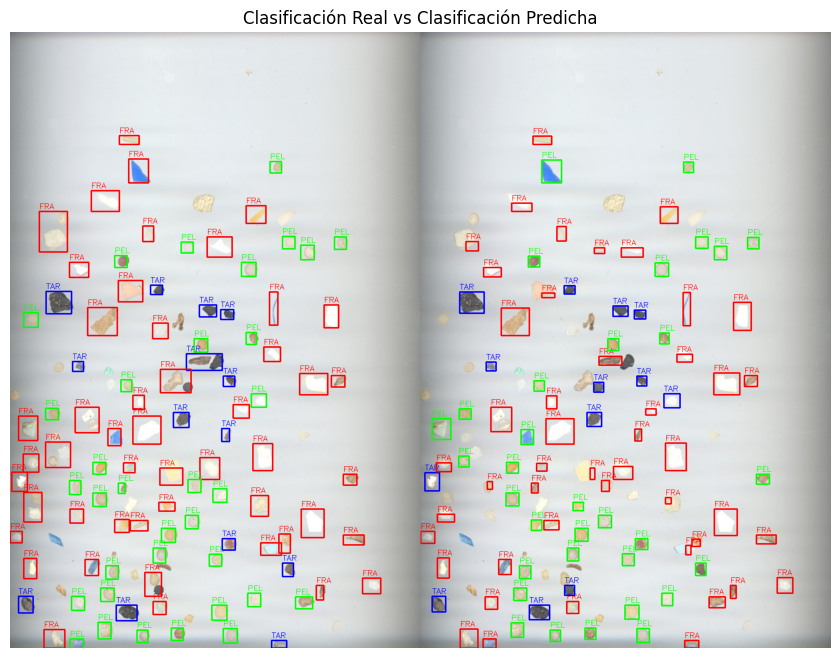


Aciertos: 70/97
Precisión global: 72.16%


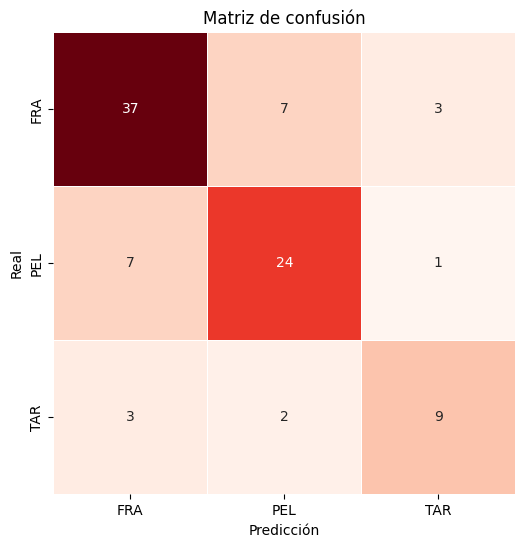


📊 MÉTRICAS DEL CLASIFICADOR
Accuracy (Exactitud): 72.16%
Precisión: 75.25%
Recall (Sensibilidad): 72.16%
Puntaje F1: 73.67%


In [17]:
imagenes_ref = {
        "FRA": "recursos/tarea2/FRA.png",
        "PEL": "recursos/tarea2/PEL.png",
        "TAR": "recursos/tarea2/TAR.png"
}

imagen_test="recursos/tarea2/MPs_test.jpg"
anotaciones_csv="recursos/tarea2/MPs_test_bbs.csv"

mean_vectors = entrenar_clasificador(imagenes_ref)
mean_vectors_norm, scaler, weights = preparar_referencias(mean_vectors)

y_true, y_pred, combined = clasificar_imagen_con_anotaciones(
    imagen_test, anotaciones_csv, mean_vectors_norm, scaler, weights
)

clases = list(imagenes_ref.keys())
mostrar_resultado_visual(y_true, y_pred, combined)
mostrar_matriz_confusion(y_true, y_pred, clases)
imprimir_metricas(y_true, y_pred)